# Decentralized Adaptive Markets

by Steve Kunath, Kevin McCabe, Aleksander Psurek

Abstract


Introduction

To engage in exchange agents go thorugh a sequence of actions:
* Find Trading Partners
* Negotiate Contract/Agreement
* Fulfill Contract/Agreement
* Reconcile Fulfillment and Build Loyalty

Each of these actions produce transaction costs that reduce the benefits of exchange.  Over time agents try to reduce transaction costs through several mechanisms:
* Centralization (physical and/or virtual)
* Innovation in institutions (rules that shift transaction costs to the institution)
* Innovation in technologies (creating improved virtualization of activities

The goal of our research is to study the dynamics of this process as a evolutionary or adaptive process that buids path dependent institutions to solve the problem of exchange.  In particular we assume that adaptation is largely a gradual process of innovation with what is known, but external shocks sometimes cause more explosive periods of innovation.  As the research progresses w hope to better understand the role of experiments, and field data in validating parts of the model and improving predictive power. 

In this paper we start with a small economy with agents already taking the role of buyers and sellers.  Using market efficeincy as a measure of performance, it is easy to demonstrate that matching costs are the largest costs in our small economy and reducing these costs create strong incentives toward centralization.  As centralization occurs matching costs are replaced by negotiation costs which are reduced by price discovery institutions.     

## Import Modules and Agent Types

In [2]:
import random as rnd
import operator
import os
import matplotlib.pyplot as plt                 # import matplotlib
import numpy as np                              # import numpy
import time
import copy
import json

# This works only if notebook is in same folder
import dm_bargain
import dm_travel
import dm_agents
import dm_env as env
import dm_utils as dm
import dm_sim_period as simp
import dm_process_results as pr
import env_make_agents as mkt

# Agent Types

ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer
trader_objects = [ZID, ZID]     


# Enviornment

> **Grid**: **g** = `grid_size` x `grid_size`
> * Agents start out in random locations on the grid
> * Agents can travel (`x + dx`, `y + dy`) in one period
> * Boundaries of grid are hard
> * where dx, dy in {-1, 0, +1}    

> **Time**: Discrete intervals representing specific events.   
> * **week:** w = 0, 1, ... `num_weeks - 1`(Reinitialization of preferences)
     * **period:** p = 0, 1, ..., `num_periods - 1` (Travel one space in grid)
        * **round:** r = 0, 1, ..., `num_rounds - 1` (Make and accept posted-offers)

**Initial Environment**:
* **w = 0**, **p = 0**, **r = 0**, `num_periods` = P, `num_rounds` = R, `num_weeks` = W,
* **g** = `grid_size` x `grid_size`,
* $e^b = (v^b, m^b, u^b, loc^b)$ for b = 0, ..., `num_traders/2`,
* $e^s = (c^s, m^s, \pi^s, loc^s)$ for s = 0, ..., `num_traders/2`.



> **Buyers** (indexed by b) 
* reservation values: $v^b = (v_1, v_2, ..., v_K), m^b$.  
* quantity bought: $q^b$
* prices paid: $p^b = (p_1, ..., p_{q^b})$
* utility:
$$u^b(q^b,p^b) = m^b + \sum_{i=1}^{q^b} v^b_i - \sum_{i = 1}^{q^b} p^b_i$$
* starting position: $e^b = (v^b, m^b, u^b, loc^b)$

> **Sellers** (indexed by s) 
* unit costs: $c^s = (c_1, c_2, ..., c_K), m^s$.  
* quantity sold: $q^s$
* prices received: $p^s = (p_1, ..., p_{q^s})$
* profit:
$$\pi^s(q^s,p^s) = m^s + \sum_{i=1}^{q^s} p^s_i - \sum_{i = 1}^{q^s} c^s_i$$
* starting position: $e^s = (c^s, m^s, \pi^s, loc^s)$

> Notes on values and costs

**Buyer Reservation Values**
```python
values = []
interval = int((self.ub-self.lb)/4
upper = self.ub
lower = self.lb + interval
for unit in range(self.num_units):
    value = np.random.randint(lower, upper+1)
    values.append(value)
return sorted(values, reverse=True)
```
**Seller Unit Costs**
```python
costs = []
interval = int((self.ub-self.lb)/4
upper = self.ub - interval
lower = self.lb
for unit in range(self.num_units):
    cost = np.random.randint(lower, upper+1)
    costs.append(cost)
return sorted(costs, reverse=False)
```

## Build environment

In [4]:
trader_objects = [(ZID, 10), (ZID, 10)]  
grid_size = 1     # Grid is grid_size x grid_size
num_traders = 20   # traders (multiple of two) 
num_units = 8     # Number of units per trader
lower_bound = 200 # lower bound on values or costs
upper_bound = 600 # upper bound on values or costs
debug = False

agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
#agent_maker.make_test_agents()
agent_maker.make_agents()
agent_maker.make_locations()
agents = agent_maker.get_agents()
agent_maker.print_agents(agents)


B_1_ZID    BUYER  @(0, 0):[  563,  518,  483,  449,  444,  439,  324,  302]cu = 0
B_2_ZID    BUYER  @(0, 0):[  580,  560,  531,  530,  380,  370,  357,  305]cu = 0
B_3_ZID    BUYER  @(0, 0):[  481,  456,  433,  407,  355,  352,  340,  340]cu = 0
B_4_ZID    BUYER  @(0, 0):[  589,  574,  537,  507,  475,  447,  378,  350]cu = 0
B_5_ZID    BUYER  @(0, 0):[  561,  553,  513,  506,  484,  431,  410,  302]cu = 0
B_6_ZID    BUYER  @(0, 0):[  553,  542,  521,  513,  425,  358,  350,  334]cu = 0
B_7_ZID    BUYER  @(0, 0):[  594,  588,  448,  428,  422,  411,  306,  300]cu = 0
B_8_ZID    BUYER  @(0, 0):[  568,  554,  517,  428,  351,  333,  324,  316]cu = 0
B_9_ZID    BUYER  @(0, 0):[  577,  461,  422,  409,  398,  382,  369,  354]cu = 0
B_10_ZID   BUYER  @(0, 0):[  583,  508,  473,  466,  403,  402,  384,  378]cu = 0
S_1_ZID    SELLER @(0, 0):[  205,  265,  282,  285,  341,  342,  391,  443]cu = 0
S_2_ZID    SELLER @(0, 0):[  207,  253,  281,  289,  299,  335,  362,  372]cu = 0
S_3_ZID    SELLE

## Present Environment as Supply and Demand

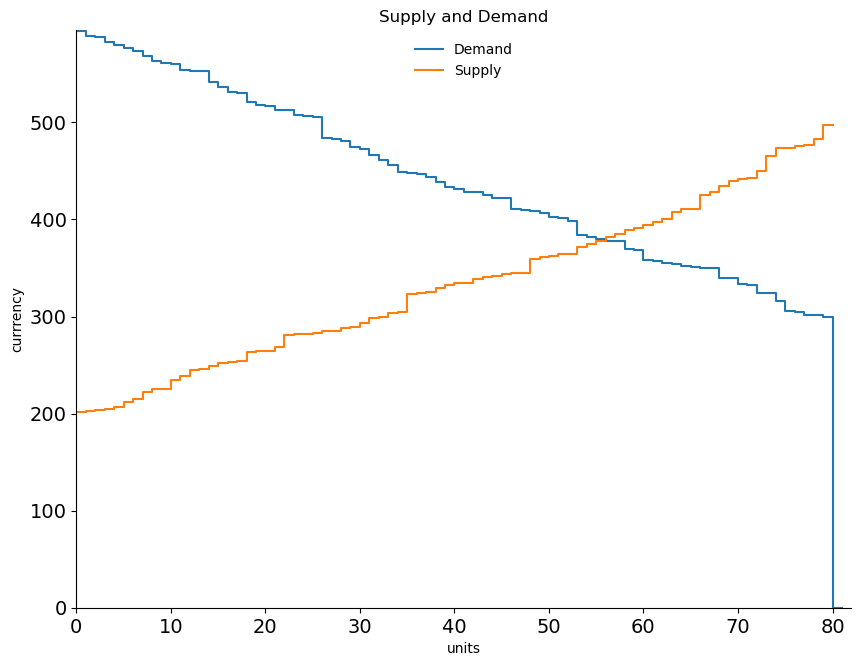

In [5]:
# set up market
agent_maker.make_market("test_market")
agent_maker.plot_market()
market = agent_maker.get_market()

## Show Equilibrium Calculations

In [6]:
agent_maker.show_equilibrium()


When market test_market is in equilibrium we have:
equilibrium price    = 378 - 380
equilibrium quantity = 56
maximum surplus      = 10996



# Institutions

## Messages

```python
class Message(object):
    """Messages will be passed as objects
    """
    def __init__(self, directive, sender, receiver, payload):
        """
           directive = string to determine call
           sender = sender name
           receiver = receiver name
           payload = payload
        """
        self.directive = directive
        self.sender = sender
        self.receiver = receiver
        self.payload = payload
        
    def get_directive(self):
        return self.directive
    
    def get_sender(self):
        return self.sender
    
    def get_receiver(self):
        return self.receiver
    
    def get_payload(self):
        return self.payload
    
    def unpack(self):
        directive = self.directive
        sender = self.sender
        receiver = self.receiver
        payload = self.payload
        return (directive, sender, receiver, payload)
    
    def print_message(self):
        d = self.get_directive()
        print(f"directive = {d}")
        print(f"sender = {self.get_sender()}")
        print(f"receiver = {self.get_receiver()}")
        print(f"payload = {self.get_payload()}")
```

```python
simulator:
    ... 
    loop through trials:
        ...
        make_agents()
        loop through weeks
            loop through periods:
                travel_institution:
                    loop through agents:
                        request move
                        if valid move -> make move
                loop through points in grid:
                    if at least one buyer and seller at point:
                        bargain_institution:
                            loop through rounds:
                                loop through agents:
                                    request "BID, ASK" 
                                    if valid -> put in order_book
                                loop through agents in random-order:
                                    request "BUY, SELL"
                                    if valid -> make contract
                                collect round_data
                    collect period_data
                collect week_data
            collect trial data
        save data_set to file 
```

# ZID Trader Strategies

## ZID

> Travel
```Python
    def move_requested(self, pl):
        """
        Make a move in a random direction if you can still trade 
        """
        direction_list = [-1, 0, +1] # 
        ...
        dx = rnd.choice(direction_list)
        dy = rnd.choice(direction_list)
        return_msg = Messsage("MOVE", self.name, "TRAVEL", (dx, dy))
        return return_msg
```

> Offer
```Python
        
        if self.type == "BUYER":
            wtp = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            return_msg = Message("BID", self.name, "BARGAIN", wtp)
            return return_msg   

        else: # for SELLER
            wta = rnd.randint(self.costs[self.cur_unit], self.upper_bound)
            return_msg = Message("ASK", self.name, "BARGAIN", wta)
            return return_msg  
```

> Transact
```python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            WTP = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            # Find open asks in order book 
            offers = []
            for trader_id in current_offers:
                if current_offers[trader_id] == None:
                    continue
                offer_type = current_offers[trader_id][0]
                offer_amount = current_offers[trader_id][1]
                if offer_type == "ASK":
                    offers.append((trader_id, offer_amount))
            # Make a random choice from offers and try to transact    
            if len(offers) > 0:
                offer = rnd.choice(offers)
                if WTP >= offer[1]:  # offer[1] = sellers willingness to accept
                    seller_id = offer[0]
                    return_msg = Message("BUY", self.name, "BARGAIN", seller_id)
                    self.returned_msg(return_msg)
                    return return_msg    
                else:
                    return_msg = Message("NULL", self.name, "BARGAIN", None)
                    self.returned_msg(return_msg)
                    return return_msg   
            else:
                return_msg = Message("NULL", self.name, "BARGAIN", None)
                self.returned_msg(return_msg)
                return return_msg
 ```           

> Transact
```python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            wtp = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            # Find open asks in order book 
            offers = []
            ...
            # Make a random choice from offers and try to transact    
            ...
                seller_id, ask = rnd.choice(offers)
                if wtp >= ask: 
                    return_msg = Message("BUY", self.name, "BARGAIN", seller_id)
                    self.returned_msg(return_msg)
                    return return_msg    
                else:
                    return_msg = Message("NULL", self.name, "BARGAIN", None)
                    self.returned_msg(return_msg)
                    return return_msg   
            ...
```          

## Sample Simulation

In [9]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:<4}-{price:4} -{s_cos:>4}:{s_cur:<3}    {buyer:10} {seller:10}")

sim_name = "Sample One Period Simulation"
num_rounds = 20
num_periods = 1
plot_on = False
debug = False

sim_agents = copy.deepcopy(agents)
contracts = []
sim1 = simp.SimPeriod(sim_name, num_rounds, sim_agents, 
                market, grid_size, debug, plot_on)
for period in range(num_periods):
    sim1.run_period()
    contracts.extend(sim1.get_contracts())

print()
contracts = sim1.get_contracts()
print_contracts(contracts)



CONTRACTS:
rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id
-------------------------------------------------------
 0   0:577 - 512 - 293:0      B_9_ZID    S_6_ZID   
 0   0:553 - 393 - 222:0      B_6_ZID    S_7_ZID   
 0   0:481 - 327 - 202:0      B_3_ZID    S_5_ZID   
 0   0:589 - 422 - 204:0      B_4_ZID    S_4_ZID   
 0   0:561 - 464 - 225:0      B_5_ZID    S_9_ZID   
 0   0:563 - 375 - 203:0      B_1_ZID    S_8_ZID   
 0   0:568 - 484 - 235:0      B_8_ZID    S_10_ZID  
 0   0:594 - 504 - 205:0      B_7_ZID    S_1_ZID   
 0   0:580 - 326 - 254:1      B_2_ZID    S_9_ZID   
 0   0:583 - 504 - 207:0      B_10_ZID   S_2_ZID   
 0   1:542 - 248 - 245:0      B_6_ZID    S_3_ZID   
 1   1:461 - 287 - 265:1      B_9_ZID    S_1_ZID   
 1   1:554 - 454 - 288:2      B_8_ZID    S_9_ZID   
 1   1:456 - 333 - 249:1      B_3_ZID    S_10_ZID  
 1   1:574 - 455 - 212:1      B_4_ZID    S_5_ZID   
 1   2:517 - 287 - 253:1      B_8_ZID    S_2_ZID   
 1   2:521 - 397 - 239:1      B_6_ZID    S_8

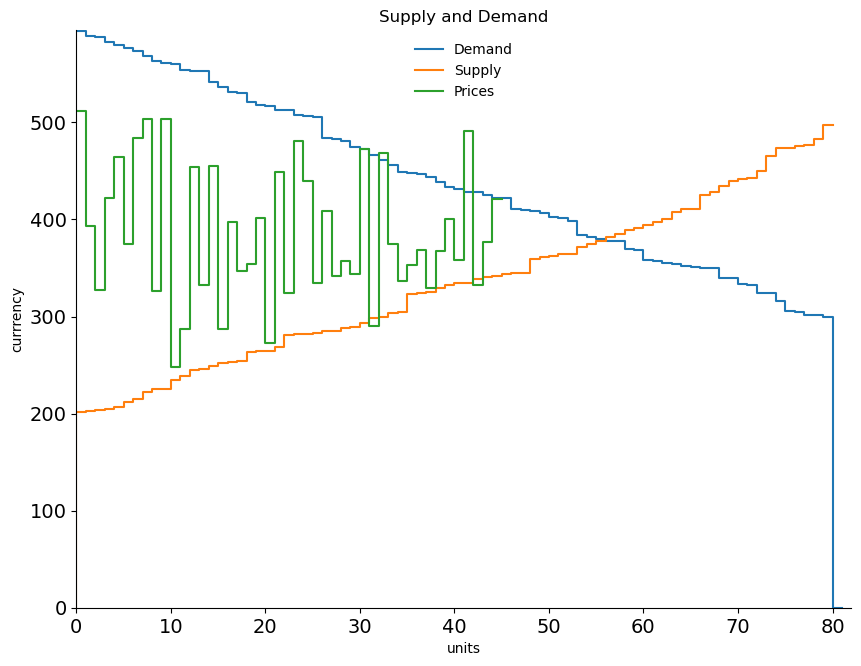

In [10]:
pr_1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
pr_1.plot_prices()

# Performance


In [ ]:
pr_1.get_results()
pr_1.display_results()


# Price Discovery

In [ ]:
prices = pr_1.get_prices()
print(prices)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  
ax.hist(prices, label = 'ZID Pricess', linestyle = 'solid', color='blue', lw =3)

ax.set_xlabel('price', size = 'x-large') 
ax.grid(1)
ax.set_ylabel('frequency', size = 'x-large') 
ax.set_title('Histogram of ZID prices with grid_size = 1', size = 'x-large')
ax.legend(fontsize='x-large')

# ZIDP Simulation

In [ ]:
trader_objects = [ZIDP, ZIDP]  
grid_size = 1     # Grid is grid_size x grid_size
num_traders = 20   # traders (multiple of two) 
num_units = 8     # Number of units per trader
lower_bound = 200 # lower bound on values or costs
upper_bound = 600 # upper bound on values or costs
debug = False

agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
#agent_maker.make_test_agents()
agent_maker.make_agents()
agent_maker.make_locations()
agents = agent_maker.get_agents()
agent_maker.print_agents(agents)


In [ ]:
# set up market
agent_maker.make_market("test_market")
agent_maker.plot_market()
market = agent_maker.get_market()

In [ ]:
agent_maker.show_equilibrium()

In [ ]:
sim_name = "Sample One Period Simulation"
num_rounds = 10
num_periods = 1
plot_on = False
debug = False

sim_agents = copy.deepcopy(agents)
contracts = []
sim1 = simp.SimPeriod(sim_name, num_rounds, sim_agents, 
                market, grid_size, debug, plot_on)
for period in range(num_periods):
    sim1.run_period()
    contracts.extend(sim1.get_contracts())

print()
contracts = sim1.get_contracts()
print_contracts(contracts)


In [ ]:
pr_1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
pr_1.plot_prices()
pr_1.get_results()
pr_1.display_results()


In [ ]:
prices = pr_1.get_prices()
print(prices)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  
ax.hist(prices, label = 'ZIDP Prices', linestyle = 'solid', color='blue', lw =3)

ax.set_xlabel('price', size = 'x-large') 
ax.grid(1)
ax.set_ylabel('frequency', size = 'x-large') 
ax.set_title('Histogram of ZIDP prices with grid_size = 1', size = 'x-large')
ax.legend(fontsize='x-large')

# Simulation Runner

## Pseudo Code for Simulation Runs 
```
Simulator:
    Get Simulator Variables: sim_name
        Make main folder: sim_name + date
    Get Control Variables
        Write variables to main folder
    Get treat_key = treatment_name, treatment_list 
    Loop through treatments (using treatment as index) 
        Loop num_trials times (using trial as index)
            Make agents (set preferences and locations)
            Loop num_weeks times (using week as index)
                Init agents (preferences and locations)
                Loop num_period times (using period as index)
                    Loop through agents (using agent as index)
                        agent makes travel decisions (upgrades grid location)
                    Loop through grid (using loc as index)
                        If there is a Buyer and Seller at loc:
                            Loop num_round times (using round as location)
                            Loop through agents@loc (using agent as index)
                                agent makes offer (Bid or Ask) in order_book
                            Loop through agents@loc in random order (using agent as index)
                                agent makes Buy or Sell decision to offer in order_book
                    Record period_data
                Record week_data
            Record session_data
        Record trial_data
       

## Folder Structure
```
dm_simulations/
    'sim_name + date'/
       'sim_name'.config
       'treatments'/
           'treatments'.config
           'treatment_id'/
               'treatment_id'.config
               'trials'/
                   'trial###'/
                       datum['id'][week][period][round]       
```

# Simulations

## Runner with treatment lists

In [ ]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:4} -{price:4}-{s_cos:4}{s_cur:3}    {buyer:10} {seller:10}")

def print_locations(agents):
    for agent in agents:
        print(f"agent {agent.name} is at location {str(agent.get_location())}")

def chk(x, index):
    typ = type(x)
    assert typ == int or typ == list, "bad type"
    if type(x) == int:
        return x
    elif type(x) == list:
        return x[index]
        
def make_simulation(controls, treat_key):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 
    treat_number = 0
    num_weeks = chk(controls['num_weeks'], treat_number)
    num_periods = chk(controls['num_periods'], treat_number)
    num_rounds = chk(controls['num_rounds'], treat_number)
    grid_sizes = chk(controls['grid_size'], treat_number)
    num_traders = chk(controls['num_traders'], treat_number)
    num_units = chk(controls['num_units'], treat_number)
    lower_bound = chk(controls['lower_bound'], treat_number)
    upper_bound = chk(controls['upper_bound'], treat_number)
    num_trials = chk(controls['num_trials'], treat_number)

    # Setup data tsructure for effs
    effs = []
    for k, treat in enumerate(controls[treat_key]):
        subeffs = []
        for trial in range(num_trials):
            subeffs.append(0)
        effs.append(subeffs)


    print('Started Simulation')
    for trial in range(num_trials):
        for index, treat in enumerate(controls[treat_key]):
            
            # collect controls
            num_periods = chk(controls['num_periods'], index)
            num_rounds = chk(controls['num_rounds'], index)
            grid_size = chk(controls['grid_size'], index)
            num_traders = chk(controls['num_traders'], index)
            num_units = chk(controls['num_units'], index)
            lower_bound = chk(controls['lower_bound'], index)
            upper_bound = chk(controls['upper_bound'], index)
            
            # make agents
            agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                        grid_size, lower_bound, upper_bound, debug)
            agent_maker.make_agents()
            agent_maker.set_locations(grid_size)
            agents = agent_maker.get_agents()

            # set up market
            agent_maker.make_market("test_market")
            market = agent_maker.get_market()
          
            # run sim
            contracts = []

            sim_agents = copy.deepcopy(agents)  # reinitialize
            sim1 = simp.SimPeriod(sim_name, num_rounds, sim_agents, 
                   market, grid_size, debug, plot_on)
            for period in range(num_periods):
                sim1.run_period()
                contracts.extend(sim1.get_contracts())
            # process results
            pr1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
            pr1.get_results()
            effs[index][trial] = pr1.get_efficiency()
    print('Finished Simulation')
    return effs



## Increase bargaining rounds

### Initialize and run

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZID]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 1,
    'num_rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grid_size': 1,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'num_rounds'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_1 = make_simulation(controls, key)


### Graph Efficiences

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_1, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

As we increase the number of bargaining rounds in a 1x1 grid the ZID agents have opportunities to make more rounds of offers. This increases the opportunity for trades and thus increases the gains from exchange.  

## Increase grid_size

### initialize and run

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZID]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 1,
    'num_rounds': 10,
    'grid_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'grid_size'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_2 = make_simulation(controls, key)


### Graph efficiencies

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_2, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

## Increase Search Periods for Agents 

### Initialize and run

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZID]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'num_rounds': 10,
    'grid_size': 5,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_3 = make_simulation(controls, key)


### Graph Efficiencies

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_3, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

##  Round Effect (using Two tables)

### Initialize and Run

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZID]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'num_rounds': 1,
    'grid_size': 5,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 50
}

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_4 = make_simulation(controls, key)
for k in data_table_4:
    print(k)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_4, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Graph Efficiencies

In [ ]:
whole_table = []
# Rearrange data in tables
for k in range(len(data_table_3)):
    whole_table.append(data_table_3[k])
    whole_table.append(data_table_4[k])
treatments = []
for k in controls['num_periods']:
    treatments.append(k)
    treatments.append(k)
print(treatments)
    


In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(whole_table, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(treatments, fontsize=12)

plt.show()

### Narrative

## Round effect for Grid Size 10 and 50 periods

### Init and run

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZID]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 30,
    'num_rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grid_size': 5,
    'num_traders': 20,
    'num_units': 10,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 50
}

key = 'num_rounds'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_5 = make_simulation(controls, key)


### Graph Efficiencies

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_5, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

# Runner for comparing efficiencies between strategies 

```python
generate agent preferences
sim_weekly_runner:
    reset agent preferences
    loop through periods
        sim_period_runner:
        ...
            travel_institution:
                loop through agents:
                    request move
                    if valid move -> make move
            loop through points in grid:
            if at least one buyer and seller at point:
                bargain_institution:
                    loop through rounds:
                        loop through agents:
                            request "BID, ASK" 
                            if valid -> put in order_book
                        loop through agents in random-order:
                            request "BUY, SELL"
                            if valid -> make contract
```

# Runner for running weeks

In [ ]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:4} -{price:4}-{s_cos:4}{s_cur:3}    {buyer:10} {seller:10}")


def print_grid(grid):
    for k_loc in grid:
        print('point', k_loc,' --> ',grid[k_loc])
        
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_simulation(sim_name, num_periods, num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    effs = []
    type_effs = []
    locs = []
  

    # make agents
    agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        grids = []
        locations = make_locs(agents)
        sim1 = simp.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size)
        for period in range(num_periods):
            sim1.run_period()
            grid = sim1.get_grid()
            grids.append(grid)
            locations.extend(make_locs(agents))
            contracts.extend(sim1.get_contracts())

        locs.append(locations)
        # process results
        pr1 = pr.ProcessResults(market, sim_name, agents, contracts)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
        type_eff = pr1.get_type_surplus()
        type_effs.append(type_eff)  
    return effs, type_effs, locs



## Test ZID

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZID]     # List of artificial traders, length 2, can be same
sim_name = "test_one"           # will be the folder name
plot_on = False                 # Plots each week
debug = False                   # Provide verbose information   

num_periods = 7
num_weeks = 2
num_rounds = 5
grid_size = 5
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_6, type_surplus_table, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)
loc_len = []
for week_locs in locs:
    for period_locs in week_locs:
        loc_d = {}
        for g_loc in loc:
            if g_loc in loc_d.keys():
                loc_d[g_loc] += 1
            else:
                loc_d[g_loc] = 1
    loc_len.append(len(loc_d))
    print('final summary')
    print(len(loc_d), loc_d)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  
ax.plot(loc_len, label = 'ZID', linestyle = 'solid', color='blue', marker = "o", lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', marker = "o", lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(-1, 50)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Test ZIDA

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZIDA, ZIDA]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_7, type_surplus_table, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

loc_len = []
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    loc_len.append(len(loc_d))
    print(len(loc_d), loc_d)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  
ax.plot(loc_len, label = 'ZID', linestyle = 'solid', color='blue', lw =3)
ax.plot(data_table_7, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid()
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Compare ZID and ZIDA efficiencies grid_size = 10

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))  
ax.plot(data_table_7, label = 'ZIDA', linestyle = 'dashed', color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Test ZIDPA

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 

trader_objects = [ZIDPA, ZIDPA]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 100
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_8, type_surplus_table, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)

## Compare ZID, ZIDA, and ZIDPA efficiencies grid_size = 10

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_8, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_7, label = 'ZIDA', linestyle = 'dotted', color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Test ZIDPR

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 
ZIDPR = dm_agents.ZIDPR 

trader_objects = [ZIDPR, ZIDPR]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 100
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_9, type_surplus_table, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)

## Compare ZID, ZIDA,  ZIDPA and ZIDPR efficiencies grid_size = 10

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_9, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.plot(data_table_8, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_7, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 100)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing strategies', size = 'x-large')
ax.legend(fontsize='x-large')

# Compare agent strategies/types competing within periods

### Initialize and run ZID vs ZIDP

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZIDP]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 100
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDP traders"

data_table_10, data_table_11, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

ZID_surplus = []
ZIDP_surplus = []
for type_surplus in data_table_11:
    if 'ZID' in type_surplus:
        ZID_surplus.append(type_surplus['ZID'])
    else:
        ZID_surplus.append(0)
    if 'ZIDP' in type_surplus:
        ZIDP_surplus.append(type_surplus['ZIDP'])
    else:
        ZIDP_surplus.append(0)   

data_table_12 = [ZID_surplus, ZIDP_surplus]

"""
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)
"""

### Graph Efficiencies

In [ ]:
fig, ax = plt.subplots()  
ax.plot(ZID_surplus, label = 'ZID')
ax.plot(ZIDP_surplus, label = 'ZIDP')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing actual surplus of ZID and ZIDP strategies')
ax.legend()

In [ ]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_monte_carlo(num_trials, num_periods, num_weeks,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    effs = []
    type_effs = []
    locs = []
  
    for trial in range(num_trials):
        make_simulation(num_periods, num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                    trader_objects)

    return effs, type_effs, locs



In [ ]:
num_trials = 100
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
trader_objects =[ZID, ZIDA]

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
make_monte_carlo(num_trials, num_periods, num_weeks,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects)

## Compare ZID vs ZIDA

In [ ]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [ZID, ZIDA]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDA traders"
data_table_13, data_table_14, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

ZID_surplus = []
ZIDA_surplus = []

for type_surplus in data_table_14:
    if 'ZID' in type_surplus:
        ZID_surplus.append(type_surplus['ZID'])
    else:
        ZID_surplus.append(0)
    if 'ZIDA' in type_surplus:
        ZIDA_surplus.append(type_surplus['ZIDA'])
    else:
        ZIDA_surplus.append(0)   

data_table_15 = [ZID_surplus, ZIDA_surplus]

"""
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)
"""

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZID_surplus, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)
ax.plot(ZIDA_surplus, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Compare ZIDPA vs ZIDA

In [ ]:
ZID = dm_agents.ZID       # name of agent class
ZIDA = dm_agents.ZIDA     # name of agent class
ZIDP = dm_agents.ZIDP     # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 

trader_objects = [ZIDPA, ZIDA]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDP traders"
data_table_16, data_table_17, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

ZIDPA_surplus = []
ZIDA_surplus = []
for type_surplus in data_table_17:
    ZIDPA_surplus.append(type_surplus['ZIDPA'])
    ZIDA_surplus.append(type_surplus['ZIDA'])

data_table_18 = [ZIDPA_surplus, ZIDA_surplus]


for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZIDPA_surplus, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(ZIDA_surplus, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZIDPA to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_16, label = 'ZIDA and ZIDPA', linestyle = 'solid', color='blue', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('50% ZIDA and 50% ZIDP', size = 'x-large')
ax.legend(fontsize='x-large')

## Compare ZIDPA to ZIDPR

In [ ]:
ZID = dm_agents.ZID       # name of agent class
ZIDA = dm_agents.ZIDA     # name of agent class
ZIDP = dm_agents.ZIDP     # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 
ZIDPR = dm_agents.ZIDPR 
trader_objects = [ZIDPA, ZIDPR]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 100
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDP traders"
data_table_19, data_table_20, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

ZIDPA_surplus = []
ZIDPR_surplus = []
for type_surplus in data_table_20:
    if 'ZIDPA' in type_surplus:
        ZIDPA_surplus.append(type_surplus['ZIDPA'])
    else:
        ZIDPA_surplus.append(0)
    if 'ZIDPR' in type_surplus:
        ZIDPR_surplus.append(type_surplus['ZIDPR'])
    else:
        ZIDPR_surplus.append(0)   


data_table_21 = [ZIDPA_surplus, ZIDPR_surplus]

for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)



In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZIDPA_surplus, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(ZIDPR_surplus, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZIDPA to ZIDPR strategies', size = 'x-large')
ax.legend(fontsize='x-large')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_19, label = '50% ZIDPA and 50% ZIDPR', linestyle = 'dashed', color='magenta', lw =3)
ax.plot(data_table_8, label = '100% ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_9, label = '100% ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

# Runner for monte carlo simulations

In [ ]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    data = {}
    
    for trial in range(num_trials):
        effs, surplus, loc = make_simulation(sim_name, num_periods, num_weeks,
                                   num_rounds, grid_size,
                                   num_traders, num_units,
                                   lower_bound, upper_bound,
                                   trader_objects)
        
        data[trial] = (effs, surplus, loc)
        num_effs = len(effs)
    return data



## efficiency data analyzer

In [ ]:
from scipy.stats import sem
# Analyze Efficiency Data
def analyze_eff_data(data_table):
    # Set up arrays to parse data into weeks
    week_effs = []
    eff_avg = []
    for week in range(num_weeks):
        eff_avg.append(0)
        week_effs.append([])

    # parse data into weeks
    for trial in data_table:
        data_trial = data_table[trial]
        trial_effs, trial_surplus, trial_locs = data_trial
        
        for k, eff in enumerate(trial_effs):
            eff_avg[k] += eff
            week_effs[k].append(eff)
            
    #calculate avg and sem for each week
    std_errors = []   
    for k in range(num_weeks):
        eff_avg[k] /= num_trials
        std_error = sem(week_effs[k])
        std_errors.append(std_error)

    return eff_avg, std_errors




## ZIDA Monte-Carlo

In [ ]:
# test monte-carlo runner

num_trials = 100
# name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
trader_objects =[ZIDA, ZIDA]

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
data_table = make_monte_carlo(num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg, std_error = analyze_eff_data (data_table)

In [ ]:
x = range(num_weeks)
y = eff_avg
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, eff_avg, label = 'ZIDA', linestyle = 'solid', color='magenta', lw =3)
ax.errorbar(x, eff_avg, yerr=std_error, fmt='.k')
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'ZIDA average efficiencies for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

## ZID Monte-Carlo

In [ ]:
# test monte-carlo runner

num_trials = 100
# name of agent class
ZID = dm_agents.ZID   # name of agent class
trader_objects =[ZID, ZID]

sim_name = "ZID MONTE-CARLO"
num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
data_table_1 = make_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg_1, std_error_1 = analyze_eff_data(data_table_1)

In [ ]:
x = range(num_weeks)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(x, eff_avg_1, label = 'ZID', linestyle = 'dotted', color='red', lw =3)
ax.errorbar(x, eff_avg_1, yerr=std_error_1, fmt='.k')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'ZIDA average efficiencies for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

## ZIDP Monte-Carlo

In [ ]:
# test monte-carlo runner

num_trials = 100
# name of agent class
ZIDP = dm_agents.ZIDP   # name of agent class
trader_objects =[ZIDP, ZIDP]

sim_name = "ZIDP MONTE_CARLO"
num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
data_table_2 = make_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg_2, std_error_2 = analyze_eff_data(data_table_2)

In [ ]:
x = range(num_weeks)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(x, eff_avg_1, label = 'ZID', linestyle = 'dotted', color='red', lw =3)
ax.errorbar(x, eff_avg_1, yerr=std_error_1, fmt='.k')

ax.plot(x, eff_avg_2, label = 'ZIDP', linestyle = 'solid', color='magenta', lw =3)
ax.errorbar(x, eff_avg_2, yerr=std_error_2, fmt='.k')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(10, 20)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'ZIDA average efficiencies for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

## ZIDPA Monte-Carlo

In [ ]:
# test monte-carlo runner

num_trials = 100
# name of agent class
ZIDPA = dm_agents.ZIDPA   # name of agent class
trader_objects =[ZIDPA, ZIDPA]

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
data_table_3 = make_monte_carlo(num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg_3, std_error_3 = analyze_data(data_table_3)

In [ ]:
x = range(num_weeks)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, eff_avg, label = 'ZIDA', linestyle = 'dotted', color='blue', lw =3)
ax.errorbar(x, eff_avg, yerr=std_errors, fmt='.k')

ax.plot(x, eff_avg_1, label = 'ZID', linestyle = 'dotted', color='red', lw =3)
ax.errorbar(x, eff_avg_1, yerr=std_error_1, fmt='.k')

ax.plot(x, eff_avg_3, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.errorbar(x, eff_avg_3, yerr=std_error_3, fmt='.k')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'ZIDA average efficiencies for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

## ZIDPR Monte-Carlo

In [ ]:
# test monte-carlo runner

num_trials = 100
# name of agent class
ZIDPR = dm_agents.ZIDPR   # name of agent class
trader_objects =[ZIDPR, ZIDPR]

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
data_table_4 = make_monte_carlo(num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg_4, std_error_4 = analyze_data(data_table_4)

In [ ]:
x = [k for k in range(num_weeks)]
xp = [k + .50 for k in x]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, eff_avg, label = 'ZIDA', linestyle = 'solid', color='blue', lw =3)
ax.errorbar(x, eff_avg, yerr=std_errors, color='blue')

ax.plot(x, eff_avg_1, label = 'ZID', linestyle = 'solid', color='red', lw =3)
ax.errorbar(x, eff_avg_1, yerr=std_error_1, color = 'red')

ax.plot(x, eff_avg_3, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.errorbar(xp, eff_avg_3, yerr=std_error_3, color = 'green')

ax.plot(x, eff_avg_4, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.errorbar(x, eff_avg_4, yerr=std_error_4, color = 'cyan')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks + 1)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'Average efficiencies + std_errors for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

## ZID vs ZIDP

In [ ]:
# test monte-carlo runner

num_trials = 500
# name of agent class
ZID = dm_agents.ZID
ZIDP = dm_agents.ZIDP   # name of agent class
trader_objects =[ZID, ZIDP]

sim_name = "ZID vs ZIDP"
num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
data_table_8 = make_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg_8, std_error_8 = analyze_eff_data(data_table_8)

In [ ]:
week_ZID_sur = []
week_ZIDP_sur = []
zid_avg = []
zidp_avg = []

for week in range(num_weeks):
    zid_avg.append(0)
    zidp_avg.append(0)
    week_ZID_sur.append([])
    week_ZIDP_sur.append([])
    
# parse data into weeks
for trial in data_table_8:
    data_trial = data_table_8[trial]
    trial_effs, trial_surplus, trial_locs = data_trial
    for k, surplus in enumerate(trial_surplus):
        if 'ZIDP' in surplus:
            sur = surplus['ZIDP']
            week_ZIDP_sur[k].append(sur)
        else:
            sur = 0
            week_ZIDP_sur[k].append(sur)
        zidp_avg[k] += sur
        
        if 'ZID' in surplus:
            sur = surplus['ZID']
            week_ZID_sur[k].append(sur)
        else:
            sur = 0
            week_ZID_sur[k].append(sur)
        zid_avg[k] += sur

#calculate avg and sem for each week
std_error_zidp = []
std_error_zid = []
for k in range(num_weeks):
    zidp_avg[k] /= num_trials
    zid_avg[k] /= num_trials
    std_error = sem(week_ZIDP_sur[k])
    std_error_zidp.append(std_error)
    std_error = sem(week_ZID_sur[k])
    std_error_zid.append(std_error)
print(zidp_avg)
print(zid_avg)


In [ ]:
x = [k for k in range(num_weeks)]
print(zid_avg)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(zid_avg, label = 'ZID', linestyle = 'solid', color='blue', lw =3)
ax.errorbar(x, zid_avg, yerr=std_error_zid, color='blue')

ax.plot(zidp_avg, label = 'ZIDP', linestyle = 'solid', color='green', lw =3)
ax.errorbar(x, zidp_avg, yerr=std_error_zidp, color = 'green')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(700, 1000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title(f'Average surplus + std_errors for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

## ZIDA vs ZIDPA

In [ ]:
# test monte-carlo runner

num_trials = 500
# name of agent class
ZIDA = dm_agents.ZIDA
ZIDPA = dm_agents.ZIDPA   # name of agent class
trader_objects =[ZIDA, ZIDPA]

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
data_table_5 = make_monte_carlo(num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg_5, std_error_5 = analyze_data(data_table_5)

In [ ]:
week_ZIDA_sur = []
week_ZIDPA_sur = []
zida_avg = []
zidpa_avg = []

for week in range(num_weeks):
    zida_avg.append(0)
    zidpa_avg.append(0)
    week_ZIDA_sur.append([])
    week_ZIDPA_sur.append([])
    
# parse data into weeks
for trial in data_table_5:
    data_trial = data_table_5[trial]
    trial_effs, trial_surplus, trial_locs = data_trial
    for k, surplus in enumerate(trial_surplus):
        if 'ZIDPA' in surplus:
            sur = surplus['ZIDPA']
            week_ZIDPA_sur[k].append(sur)
        else:
            sur = 0
            week_ZIDPA_sur[k].append(sur)
        zidpa_avg[k] += sur
        
        if 'ZIDA' in surplus:
            sur = surplus['ZIDA']
            week_ZIDA_sur[k].append(sur)
        else:
            sur = 0
            week_ZIDA_sur[k].append(sur)
        zida_avg[k] += sur

#calculate avg and sem for each week
std_error_zidpa = []
std_error_zida = []
for k in range(num_weeks):
    zidpa_avg[k] /= num_trials
    zida_avg[k] /= num_trials
    std_error = sem(week_ZIDPA_sur[k])
    std_error_zidpa.append(std_error)
    std_error = sem(week_ZIDA_sur[k])
    std_error_zida.append(std_error)
print(zidpa_avg)
print(zida_avg)

In [ ]:
x = [k for k in range(num_weeks)]
print(zida_avg)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(zida_avg, label = 'ZIDA', linestyle = 'solid', color='blue', lw =3)
ax.errorbar(x, zida_avg, yerr=std_error_zida, color='blue')

ax.plot(zidpa_avg, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.errorbar(x, zidpa_avg, yerr=std_error_zidpa, color = 'green')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(1000, 6000)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'Average surplus + std_errors for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

## ZIDPA vs ZIDPR

In [ ]:
# test monte-carlo runner

num_trials = 100
# name of agent class
ZIDPR = dm_agents.ZIDPR
ZIDPA = dm_agents.ZIDPA   # name of agent class
trader_objects =[ZIDPR, ZIDPA]

sim_name = "ZIDPA_ZIDPR"
num_trials = 500
num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 20
num_traders = 30
num_units = 8
lower_bound = 200 
upper_bound = 600

data_table_5 = make_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects)

eff_avg_5, std_error_5 = analyze_data(data_table_5)

In [ ]:
x = [k for k in range(num_weeks)]
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(x, eff_avg_1, label = 'ZID', linestyle = 'solid', color='red', lw =3)
ax.errorbar(x, eff_avg_1, yerr=std_error_1, color = 'red')

ax.plot(x, eff_avg_3, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.errorbar(x, eff_avg_3, yerr=std_error_3, color = 'green')

ax.plot(x, eff_avg_4, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.errorbar(x, eff_avg_4, yerr=std_error_4, color = 'cyan')

ax.plot(x, eff_avg_5, label = '50% ZIDPR and 50% ZIDPA', linestyle = 'solid', color='magenta', lw =3)
ax.errorbar(x, eff_avg_5, yerr=std_error_5, color = 'blue')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks + 1)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'Average efficiencies + std_errors for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')

In [ ]:
week_ZIDPR_sur = []
week_ZIDPA_sur = []
zidpr_avg = []
zidpa_avg = []

for week in range(num_weeks):
    zidpr_avg.append(0)
    zidpa_avg.append(0)
    week_ZIDPR_sur.append([])
    week_ZIDPA_sur.append([])
    
# parse data into weeks
for trial in data_table_5:
    data_trial = data_table_5[trial]
    trial_effs, trial_surplus, trial_locs = data_trial
    for k, surplus in enumerate(trial_surplus):
        if 'ZIDPA' in surplus:
            sur = surplus['ZIDPA']
            week_ZIDPA_sur[k].append(sur)
        else:
            sur = 0
            week_ZIDPA_sur[k].append(sur)
        zidpa_avg[k] += sur
        
        if 'ZIDPR' in surplus:
            sur = surplus['ZIDPR']
            week_ZIDPR_sur[k].append(sur)
        else:
            sur = 0
            week_ZIDPR_sur[k].append(sur)
        zidpr_avg[k] += sur

#calculate avg and sem for each week
std_error_zidpa = []
std_error_zidpr = []
for k in range(num_weeks):
    zidpa_avg[k] /= num_trials
    zidpr_avg[k] /= num_trials
    std_error = sem(week_ZIDPA_sur[k])
    std_error_zidpa.append(std_error)
    std_error = sem(week_ZIDPR_sur[k])
    std_error_zidpr.append(std_error)
print(zidpa_avg)
print(zidpr_avg)

In [ ]:
x = [k for k in range(num_weeks)]
print(zida_avg)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(zidpr_avg, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.errorbar(x, zidpr_avg, yerr=std_error_zidpr, color='blue')

ax.plot(zidpa_avg, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.errorbar(x, zidpa_avg, yerr=std_error_zidpa, color = 'green')

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 5000)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title(f'Average surplus + std_errors for {num_trials} trials', size = 'x-large')
ax.legend(fontsize='x-large')